In [ ]:
## Modified VGG-16

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
import tensorflow as tf
from tensorflow.keras import regularizers, optimizers

print(tf.__version__)

2.5.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!ls /content/drive/'My Drive'/CML/

Image_classification_data.zip


In [5]:
!cp /content/drive/'My Drive'/CML/Image_classification_data.zip .
!unzip -q -o Image_classification_data.zip
!rm Image_classification_data.zip
!ls

data_labels_extraData.csv  drive     patch_images
data_labels_mainData.csv   __MACOSX  sample_data


In [37]:
import pandas as pd
import numpy as np
data1 = pd.read_csv('./data_labels_mainData.csv',delimiter=',')
data1.head(5)


,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


In [38]:
data1.drop('cellType', inplace=True, axis=1)
data1.drop('cellTypeName', inplace=True, axis=1)

In [39]:
data1.head(5)


,InstanceID,patientID,ImageName,isCancerous
0,22405,1,22405.png,0
1,22406,1,22406.png,0
2,22407,1,22407.png,0
3,22408,1,22408.png,0
4,22409,1,22409.png,0


In [40]:
index = data1.index
number_of_rows = len(index)
print(number_of_rows)

9896


In [41]:
data_extra = pd.read_csv('./data_labels_extraData.csv',delimiter=',')
data_extra.head(5)

,InstanceID,patientID,ImageName,isCancerous
0,12681,61,12681.png,0
1,12682,61,12682.png,0
2,12683,61,12683.png,0
3,12684,61,12684.png,0
4,12685,61,12685.png,0


In [42]:
frames = [data1, data_extra]
data = pd.concat(frames)

In [43]:
data.head(5)

,InstanceID,patientID,ImageName,isCancerous
0,22405,1,22405.png,0
1,22406,1,22406.png,0
2,22407,1,22407.png,0
3,22408,1,22408.png,0
4,22409,1,22409.png,0


In [44]:
index_f = data.index
number_of_rows_f = len(index_f)
print(number_of_rows_f)

20280


In [45]:
data['ImagePath'] = 'patch_images/' + data['ImageName'].astype(str)
data.head(5)

,InstanceID,patientID,ImageName,isCancerous,ImagePath
0,22405,1,22405.png,0,patch_images/22405.png
1,22406,1,22406.png,0,patch_images/22406.png
2,22407,1,22407.png,0,patch_images/22407.png
3,22408,1,22408.png,0,patch_images/22408.png
4,22409,1,22409.png,0,patch_images/22409.png


In [46]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, stratify = data.patientID)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42, stratify = train_data.patientID)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 12168, Val Data: 4056, Test Data: 4056


In [47]:
train_data.head()

,InstanceID,patientID,ImageName,isCancerous,ImagePath
492,11555,65,11555.png,1,patch_images/11555.png
7585,7448,88,7448.png,1,patch_images/7448.png
3853,5431,78,5431.png,1,patch_images/5431.png
5814,19871,33,19871.png,0,patch_images/19871.png
70,18832,3,18832.png,0,patch_images/18832.png


(array([7926.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        4242.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

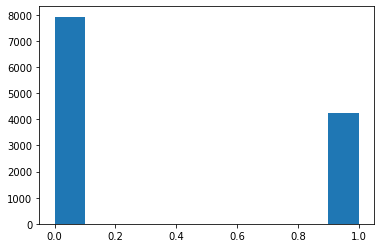

In [48]:
import matplotlib.pyplot as plt
target=train_data['isCancerous']
plt.hist(target)

In [49]:
cancerCell_df = train_data.groupby('isCancerous').first()

cancerCell_df['index'] = range(1, len(cancerCell_df) + 1)


In [50]:
cancerCell_df = cancerCell_df.reset_index()


In [51]:
cancerCell_df

,isCancerous,InstanceID,patientID,ImageName,ImagePath,index
0,0,19871,33,19871.png,patch_images/19871.png,1
1,1,11555,65,11555.png,patch_images/11555.png,2


In [52]:

cancerCell_df['isCancerous'] = cancerCell_df['isCancerous'].astype('str')

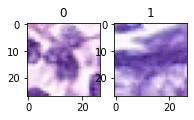

In [53]:
from PIL import Image
img_list=list(cancerCell_df.ImagePath)
target_list=list(target)

for i,rows in cancerCell_df.iterrows():
  plt.subplot(1,4,rows['index'])
  img = Image.open(rows['ImagePath'])

  plt.imshow(img)
  plt.title(rows['isCancerous'])


In [54]:
img=Image.open(img_list[1])
img_numpy = np.ascontiguousarray(img, dtype=np.float32)
print('Image size \nH: W:{} C:{}'.format(img_numpy.shape[0],img_numpy.shape[1],img_numpy.shape[2]))

Image size 
H: W:27 C:27


In [55]:
import matplotlib.pyplot as plt
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

In [56]:
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 2

In [57]:
train_data['isCancerous'] = train_data['isCancerous'].astype('str')
val_data['isCancerous'] = val_data['isCancerous'].astype('str')

In [58]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./',
        x_col="ImagePath",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./',
        x_col="ImagePath",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 12168 validated image filenames belonging to 2 classes.
Found 4056 validated image filenames belonging to 2 classes.


In [59]:
test_data['isCancerous'] = test_data['isCancerous'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./',
        x_col="ImagePath",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 4056 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
## CNN using VGG-16.  Now lets Try a Moified version of VGG-16 architecture
##Base Model

In [ ]:

model_VGG_1 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
  
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

In [ ]:
model_VGG_1.compile(optimizer='sgd',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [ ]:
history_VGG_1 = model_VGG_1.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


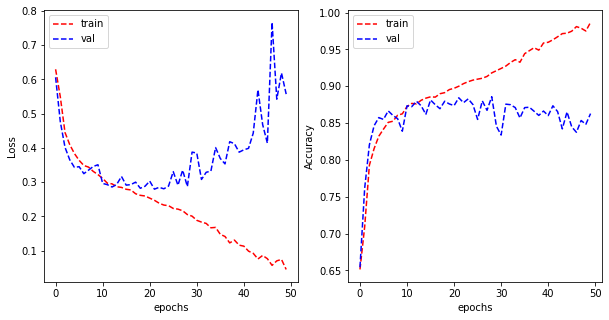

In [ ]:
plot_learning_curve(history_VGG_1.history['loss'], history_VGG_1.history['val_loss'], 
                    history_VGG_1.history['categorical_accuracy'], history_VGG_1.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [ ]:
# Hyperparameter tuning to improve overfitting by chnaging regularization lambda, learning rate of optimizer and dense layer

In [29]:
def build_model_VGG(reg_lambda, learning_rate, dense_layer):
    model_VGG = tf.keras.Sequential([
        #VGG block 1
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                               kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                               kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
        tf.keras.layers.MaxPooling2D((2, 2)),

        #VGG block 2
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                               kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                               kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
        tf.keras.layers.MaxPooling2D((2, 2)),

        #VGG block 3
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                               kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                               kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(dense_layer, activation='relu'),
        #tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(OUTPUT_CLASSES),
    ])
    
    model_VGG.compile(optimizer=tf.keras.optimizers.SGD(learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])
    
    monitor=EarlyStopping(monitor='val_loss',min_delta=1e-5,patience=80,verbose=1,restore_best_weights=True)
    model_history = model_VGG.fit_generator(train_generator, validation_data = validation_generator,callbacks = [monitor], epochs=100, verbose=0)

    plot_learning_curve(model_history.history['loss'], model_history.history['val_loss'], 
                    model_history.history['categorical_accuracy'], model_history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')
    
    print("Performance on test data: ", str(model_VGG.evaluate(test_generator)))
        
    return model_VGG

Training for reg_lamda = 0.001 , learning_rate= 0.001 , Neurons in dense layer= 128


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


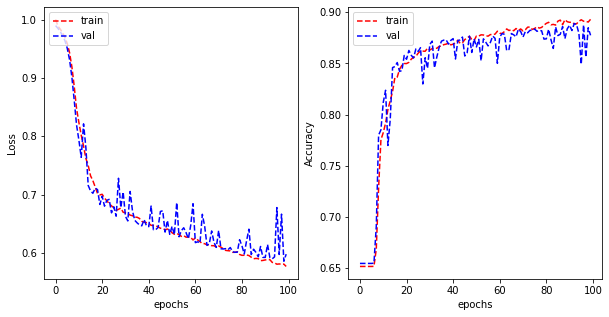

4056/4056 [==============================] - 13s 3ms/step - loss: 0.5970 - categorical_accuracy: 0.8777
Performance on test data:  [0.5969934463500977, 0.8777120113372803]
* End of iteration *

Training for reg_lamda = 0.001 , learning_rate= 0.001 , Neurons in dense layer= 256


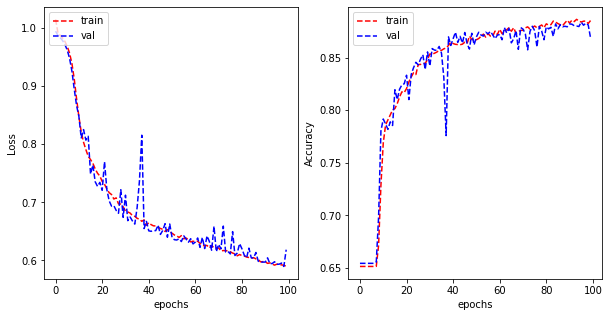

4056/4056 [==============================] - 13s 3ms/step - loss: 0.6184 - categorical_accuracy: 0.8693
Performance on test data:  [0.6183871626853943, 0.8693293929100037]
* End of iteration *

Training for reg_lamda = 0.001 , learning_rate= 0.01 , Neurons in dense layer= 128


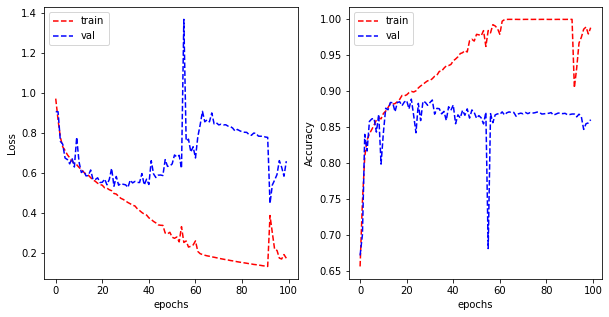

4056/4056 [==============================] - 13s 3ms/step - loss: 0.6496 - categorical_accuracy: 0.8639
Performance on test data:  [0.64960777759552, 0.8639053106307983]
* End of iteration *

Training for reg_lamda = 0.001 , learning_rate= 0.01 , Neurons in dense layer= 256


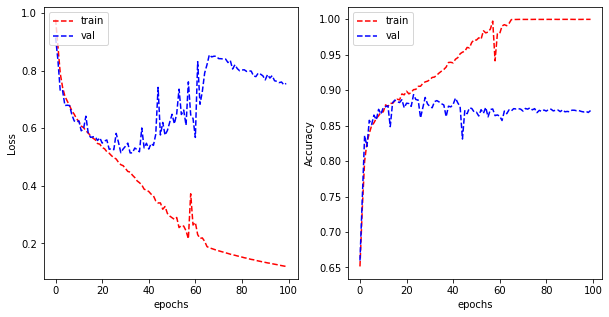

4056/4056 [==============================] - 13s 3ms/step - loss: 0.7839 - categorical_accuracy: 0.8659
Performance on test data:  [0.783946692943573, 0.8658776879310608]
* End of iteration *

Training for reg_lamda = 0.01 , learning_rate= 0.001 , Neurons in dense layer= 128


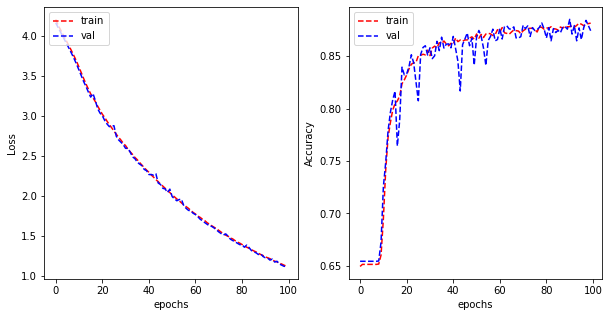

4056/4056 [==============================] - 13s 3ms/step - loss: 1.1241 - categorical_accuracy: 0.8748
Performance on test data:  [1.1240698099136353, 0.874753475189209]
* End of iteration *

Training for reg_lamda = 0.01 , learning_rate= 0.001 , Neurons in dense layer= 256


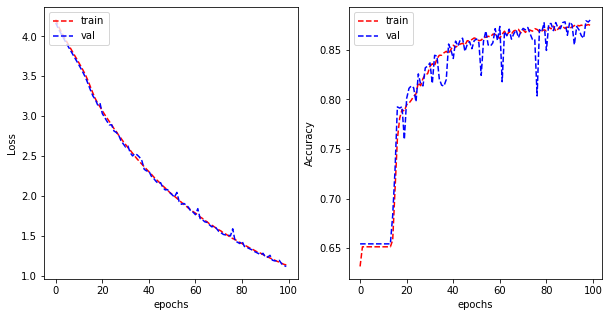

4056/4056 [==============================] - 14s 3ms/step - loss: 1.1204 - categorical_accuracy: 0.8780
Performance on test data:  [1.1203927993774414, 0.8779585957527161]
* End of iteration *

Training for reg_lamda = 0.01 , learning_rate= 0.01 , Neurons in dense layer= 128


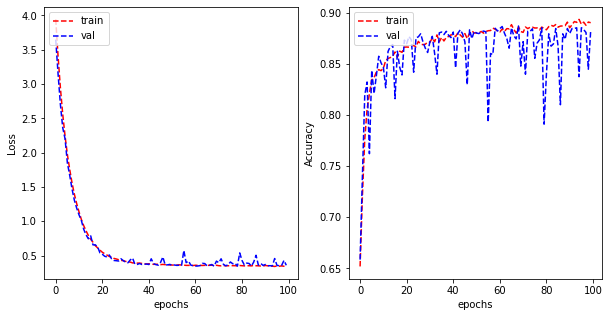

4056/4056 [==============================] - 13s 3ms/step - loss: 0.3636 - categorical_accuracy: 0.8814
Performance on test data:  [0.36359769105911255, 0.8814102411270142]
* End of iteration *

Training for reg_lamda = 0.01 , learning_rate= 0.01 , Neurons in dense layer= 256


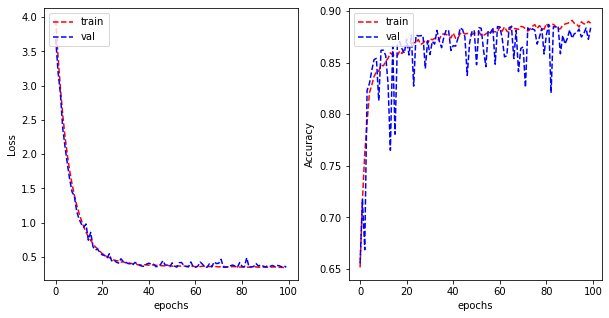

4056/4056 [==============================] - 13s 3ms/step - loss: 0.3500 - categorical_accuracy: 0.8856
Performance on test data:  [0.3499603569507599, 0.8856015801429749]
* End of iteration *

Training for reg_lamda = 0.1 , learning_rate= 0.001 , Neurons in dense layer= 128


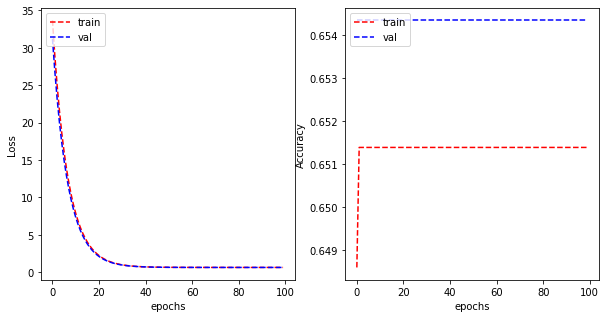

4056/4056 [==============================] - 13s 3ms/step - loss: 0.6483 - categorical_accuracy: 0.6487
Performance on test data:  [0.648317277431488, 0.648668646812439]
* End of iteration *

Training for reg_lamda = 0.1 , learning_rate= 0.001 , Neurons in dense layer= 256


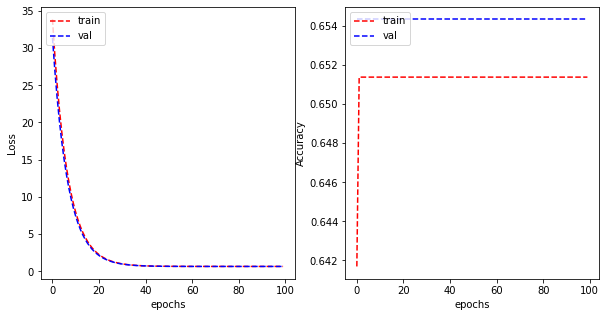

4056/4056 [==============================] - 14s 3ms/step - loss: 0.6483 - categorical_accuracy: 0.6487
Performance on test data:  [0.6483018398284912, 0.648668646812439]
* End of iteration *

Training for reg_lamda = 0.1 , learning_rate= 0.01 , Neurons in dense layer= 128
Restoring model weights from the end of the best epoch.
Epoch 00094: early stopping


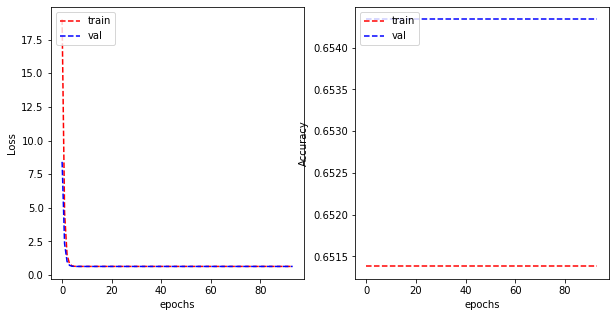

4056/4056 [==============================] - 14s 3ms/step - loss: 0.6483 - categorical_accuracy: 0.6487
Performance on test data:  [0.6483458280563354, 0.648668646812439]
* End of iteration *

Training for reg_lamda = 0.1 , learning_rate= 0.01 , Neurons in dense layer= 256
Restoring model weights from the end of the best epoch.
Epoch 00093: early stopping


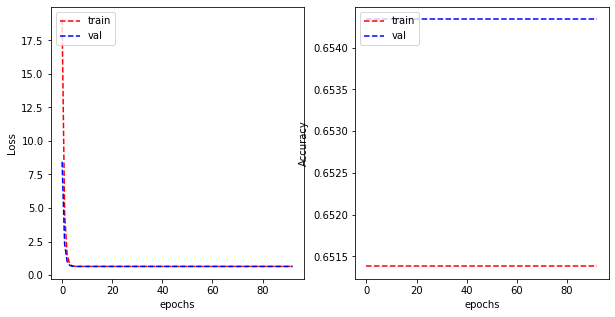

4056/4056 [==============================] - 14s 3ms/step - loss: 0.6483 - categorical_accuracy: 0.6487
Performance on test data:  [0.6483082175254822, 0.648668646812439]
* End of iteration *



In [30]:
reg_lambda = [0.001, 0.01, 0.1]
learning_rate = [0.001, 0.01]
dense_layer = [128, 256]

for reg in reg_lambda:
    for lr in learning_rate:
        for dl in dense_layer:
            print("Training for reg_lamda =",reg,", learning_rate=",lr,", Neurons in dense layer=",dl)
                
            build_model_VGG(reg, lr, dl)
        
            print("* End of iteration *")
            
            print()

In [ ]:
##Trying Data Augmentation to further improve accuracy and overfitting with reduced model complexity

In [30]:
train_data['isCancerous'] = train_data['isCancerous'].astype('str')
val_data['isCancerous'] = val_data['isCancerous'].astype('str')

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last',
                                   rotation_range=15, width_shift_range=0.2,
                                   height_shift_range=0.2, brightness_range=[0.5,1.5])
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./',
        x_col="ImagePath",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./',
        x_col="ImagePath",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 12168 validated image filenames belonging to 2 classes.
Found 4056 validated image filenames belonging to 2 classes.


In [31]:
# reduced model complexity with last block of VGG having 64 kernels in the convolution layer and adding dropout layer
reg_lambda = 0.01
activation='relu'

model_VGG_3 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),

    
    #VGG block 3
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),

    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=activation, kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

In [33]:
sgd = optimizers.SGD(lr=0.001, nesterov=True)
model_VGG_3.compile(optimizer=sgd,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


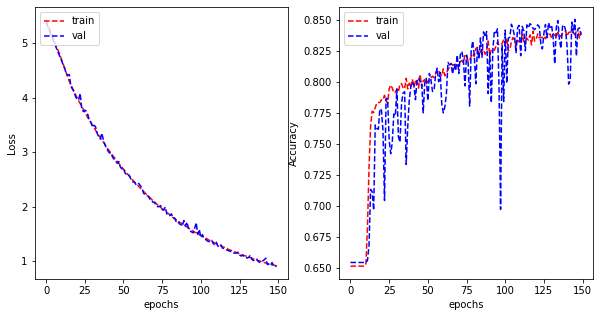

In [34]:
from tensorflow.keras.callbacks import EarlyStopping

monitor=EarlyStopping(monitor='val_loss',min_delta=1e-5,patience=80,verbose=1,restore_best_weights=True)

history_VGG_3 = model_VGG_3.fit_generator(train_generator, validation_data = validation_generator, callbacks=[monitor], epochs=150, verbose=0)

plot_learning_curve(history_VGG_3.history['loss'], history_VGG_3.history['val_loss'], 
                    history_VGG_3.history['categorical_accuracy'], history_VGG_3.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [ ]:
# The above model performance has too much oscillations.

In [ ]:
#Merged Data and Best model

In [60]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./',
        x_col="ImagePath",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./',
        x_col="ImagePath",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 12168 validated image filenames belonging to 2 classes.
Found 4056 validated image filenames belonging to 2 classes.


In [61]:
test_data['isCancerous'] = test_data['isCancerous'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./',
        x_col="ImagePath",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 4056 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [62]:
reg_lambda = 0.01

model_VGG_5 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    
    #VGG block 3
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
   
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

In [63]:
sgd = optimizers.SGD(lr=0.001, nesterov=True)
model_VGG_5.compile(optimizer=sgd,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


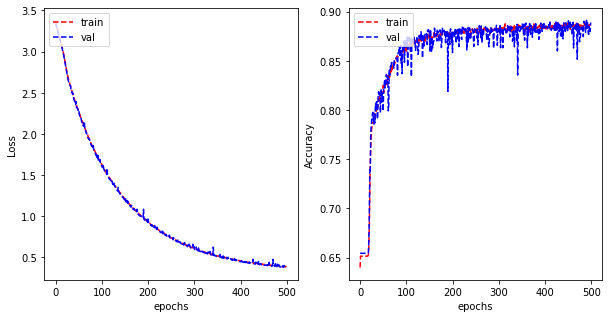

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

monitor=EarlyStopping(monitor='val_loss',min_delta=1e-5,patience=80,verbose=1,restore_best_weights=True)

history_VGG_5 = model_VGG_5.fit_generator(train_generator, validation_data = validation_generator, callbacks=[monitor], epochs=500, verbose=0)

plot_learning_curve(history_VGG_5.history['loss'], history_VGG_5.history['val_loss'], 
                    history_VGG_5.history['categorical_accuracy'], history_VGG_5.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [ ]:
model_VGG_5.evaluate(train_generator)

191/191 [==============================] - 3s 15ms/step - loss: 0.3740 - categorical_accuracy: 0.8918


[0.37399399280548096, 0.8918474912643433]

In [ ]:
model_VGG_5.evaluate(validation_generator)

64/64 [==============================] - 1s 15ms/step - loss: 0.3777 - categorical_accuracy: 0.8888


[0.377709299325943, 0.8888067007064819]

In [ ]:
model_VGG_5.evaluate(test_generator)

4056/4056 [==============================] - 12s 3ms/step - loss: 0.3832 - categorical_accuracy: 0.8866


[0.3831988275051117, 0.8865877985954285]

In [ ]:
y_hat_all = list()
y_all = list()
filenames = test_generator.filenames
N_images = len(filenames)
batches = 0

# iterate through the data generator and predict for each batch
# hold the predictions and labels
for x,y in test_generator:
        y_hat = model_VGG_5.predict(x, verbose=0)
        y_hat = np.argmax(y_hat, axis = 1)
        y = np.argmax(y, axis = 1)
        y_hat_all = y_hat_all + y_hat.tolist()
        y_all = y_all + y.tolist()

        batches += 1
        if batches >= N_images / batch_size:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break

# now you have made the predictions you can use any performance metric
# you wish: either in sklearn or some function you have written

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

print("Accuracy score: ", accuracy_score(y_all, y_hat_all))
print("F1 score: ", f1_score(y_all, y_hat_all, average='macro'))
print("Precision Score: ", precision_score(y_all, y_hat_all, average="macro"))
print("Recall Score: ", recall_score(y_all,y_hat_all, average="macro"))
print("ROC-AUC Score: ", roc_auc_score(y_all,y_hat_all, average="macro"))

print(confusion_matrix(y_all, y_hat_all))

Accuracy score:  0.8865877712031558
F1 score:  0.8750605358007655
Precision Score:  0.8767163383275811
Recall Score:  0.873497769509292
ROC-AUC Score:  0.873497769509292
[[2414  217]
 [ 243 1182]]


In [ ]:
# We did not choose to aadress the class imbalance problem in predicting the the cancerous cell because of the fact that all the models in Lenet, VGG or MLP were performing good in all performance metric. May be bacause of the fact that we used 20000 observations to train the model.